# Import dependencies

In [1]:
import pandas as pd       
import numpy as np    
import requests           
import geopandas as gpd    
import shapely
from shapely.geometry import LineString  

print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"requests version: {requests.__version__}")
print(f"geopandas version: {gpd.__version__}")
print(f"shapely version: {shapely.__version__}")

/Users/tunmiseraji/opt/anaconda3/envs/gee/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/var/folders/_5/8f5ftmj51l75p56kwm3jxr700000gn/T/ipykernel_14588/2927781437.py:4: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this 

pandas version: 1.5.3
numpy version: 1.23.5
requests version: 2.29.0
geopandas version: 0.13.2
shapely version: 2.0.4


# Download roads

In [2]:
# Define the Overpass API URL
overpass_url = "http://overpass-api.de/api/interpreter"

# Define the bounding box for Africa (approximately)
# Coordinates are (min_latitude, min_longitude, max_latitude, max_longitude)
bbox = (-35.0, -26.0, 38.0, 59.0)

# Function to create a grid of bounding boxes
def create_bbox_grid(min_lat, min_lon, max_lat, max_lon, n):
    lat_points = np.linspace(min_lat, max_lat, n+1)
    lon_points = np.linspace(min_lon, max_lon, n+1)
    bboxes = []
    for i in range(n):
        for j in range(n):
            bboxes.append((lat_points[i], lon_points[j], lat_points[i+1], lon_points[j+1]))
    return bboxes

# Define the number of divisions per side
divisions = 2
bboxes = create_bbox_grid(bbox[0], bbox[1], bbox[2], bbox[3], divisions)


# Function to fetch data for a given bounding box
def fetch_bbox_data(bbox):
    print(bbox)
    overpass_query = f"""
    [out:json][timeout:3600];
    (
      way["highway"~"motorway|trunk|primary|secondary|tertiary"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
      node(w);
    );
    out body;
    >;
    """
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()
    nodes = {element['id']: (element['lon'], element['lat']) for element in data['elements'] if element['type'] == 'node'}
    
    def extract_attributes(element):
        tags = element.get('tags', {})
        node_ids = element.get('nodes', [])
        coords = [nodes[node_id] for node_id in node_ids if node_id in nodes]
        return {
            'osmid': element['id'],
            'highway': tags.get('highway'),
            'surface': tags.get('surface'),
            'width': tags.get('width'),
            'lanes': tags.get('lanes'),
            'oneway': tags.get('oneway', 'no') == 'yes',
            'geometry': LineString(coords) if coords else None
        }

    ways = [extract_attributes(element) for element in data['elements'] if element['type'] == 'way']
    gdf_edges = gpd.GeoDataFrame([way for way in ways if way['geometry'] is not None])
    gdf_edges.set_crs(epsg=4326, inplace=True)
    
    return gdf_edges

# Fetch data for all bounding boxes and combine
gdfs = [fetch_bbox_data(bbox) for bbox in bboxes]
gdf_combined = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

# Check the size of the resulting GeoDataFrame
print(f"Number of rows: {gdf_combined.shape[0]}")

# Print info about the GeoDataFrame
print(gdf_combined.info())

output_filename = "data/Africa_roads_raw.shp"
# Save the GeoDataFrame to a shapefile
gdf_combined.to_file(output_filename)

(-35.0, -26.0, 1.5, 16.5)
(-35.0, 16.5, 1.5, 59.0)
(1.5, -26.0, 38.0, 16.5)
(1.5, 16.5, 38.0, 59.0)
Number of rows: 1755562
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1755562 entries, 0 to 1755561
Data columns (total 7 columns):
 #   Column    Dtype   
---  ------    -----   
 0   osmid     int64   
 1   highway   object  
 2   surface   object  
 3   width     object  
 4   lanes     object  
 5   oneway    bool    
 6   geometry  geometry
dtypes: bool(1), geometry(1), int64(1), object(4)
memory usage: 82.0+ MB
None


<AxesSubplot:>

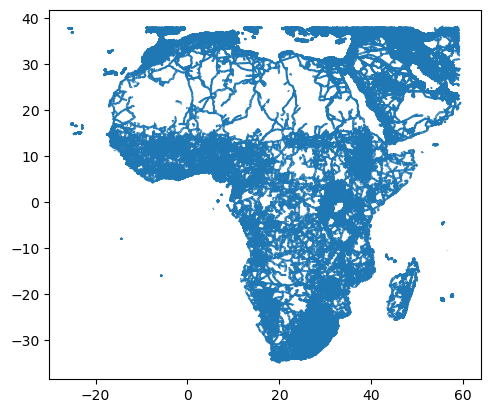

In [3]:
gdf_combined.plot()